In [22]:
import imageio
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import matplotlib.patches as patches
from skimage.draw import polygon_perimeter
import scipy.ndimage
import cv2

In [23]:
oi = imageio.imread('data/input-rotready/train_data/train/race_track/race_track_0/race_track_26/race_track_0_4_rgb.jpg')

In [24]:
f = json.load(open('data/input-rotready/train_data/train/race_track/race_track_0/race_track_26/race_track_0_4_rgb_features.json'))

In [25]:
f

[0.548247814178,
 0.4915254237288136,
 0.8571428571428571,
 0.1,
 2014.0,
 0.4166666666666667,
 0.4838709677419355,
 11.966666666666667,
 0.0,
 0.548247814178,
 2.19714355469,
 0.2384486304388889,
 0.48965619405,
 0.6397031572133334,
 0.2677085664533333,
 261.0,
 184.0,
 911.0,
 568.0,
 3.0,
 3.0]

In [26]:
sx,sy = f[15:17]
x_side, y_side = sx/2, sy/2


In [27]:
sx

261.0

In [28]:
sy

184.0

In [29]:
oi.shape

(598, 598, 3)

In [30]:
l = oi.shape[0] / 2 #(1 * 1.4142135624)
max_side = np.sqrt((x_side ** 2 ) + (y_side **2)) * 1.4142135624
scaling = oi.shape[0] / (max_side*2)


In [31]:
def rect_coords(img_shape, sx, sy):
    x0 = (img_shape[1] - sx)/2
    x1 = x0 + sx
    y0 = (img_shape[0] - sy)/ 2
    y1 = y0 + sy
    return np.array([x0, x1, x1, x0]), np.array([y0 ,y0, y1,y1])

                                            
def rotate(a, angle, img_shape):
    center = np.array([img_shape[1], img_shape[0]]) / 2.
    theta = (angle/180.) * np.pi
    rotMatrix = np.array([[np.cos(theta), -np.sin(theta)], 
                          [np.sin(theta),  np.cos(theta)]])
    return np.dot(a - center, rotMatrix) + center

def enclosing_rect(edges):
    x0 = np.amin(edges[:,0])
    x1 = np.amax(edges[:,0])
    y0 = np.amin(edges[:,1])
    y1 = np.amax(edges[:,1])
    return np.array(([x0,y0], [x1,y0], [x1,y1], [x0,y1]))

(array([ 126.19926634,  471.80073366,  471.80073366,  126.19926634]), array([ 177.17879313,  177.17879313,  420.82120687,  420.82120687]))
[[ 126.19926634  177.17879313]
 [ 471.80073366  177.17879313]
 [ 471.80073366  420.82120687]
 [ 126.19926634  420.82120687]]
[[ 126.19926634  471.80073366  471.80073366  126.19926634]
 [ 177.17879313  177.17879313  420.82120687  420.82120687]]


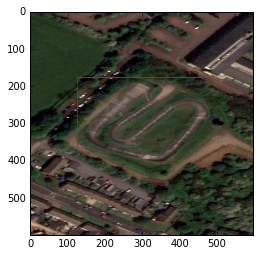

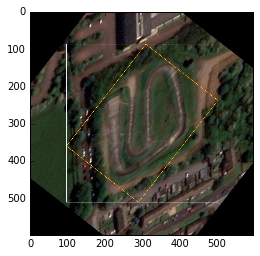

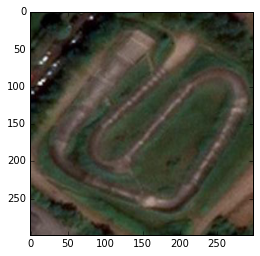

In [32]:
angle=52
i = np.array(oi)
print(rect_coords(i.shape, sx*scaling, sy*scaling))
edges = np.squeeze(np.dstack(rect_coords(i.shape, sx*scaling, sy*scaling)))
print(edges)
print(edges.transpose(1,0))
rot_points = rotate(edges, angle, i.shape)
rr, cc = polygon_perimeter(*rect_coords(i.shape, sx*scaling, sy*scaling), shape=i.shape, clip=True)
i[cc,rr,:] = (255,0,0)
plt.imshow(i)
plt.show()

rows,cols = i.shape[:2]
M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
i = cv2.warpAffine(i,M,(cols,rows))
        
#i = scipy.ndimage.interpolation.rotate(i, angle=angle, reshape=False, mode='constant', cval=np.nan)
rr, cc = polygon_perimeter(*(rot_points.transpose(1,0)), shape=i.shape, clip=True)
i[cc,rr,:] = (255,255,0)


rr, cc = polygon_perimeter(*(enclosing_rect(rot_points).transpose(1,0)), shape=i.shape, clip=True)
i[cc,rr,:] = (255,255,255)

plt.imshow(i)
plt.show()

# for inference
CROP_SIZE = 299
CONTEXT = 1.05
new_bbox = enclosing_rect(np.squeeze(np.dstack(rect_coords(i.shape, CONTEXT*sx*scaling, CONTEXT*sy*scaling))))
p0 = new_bbox[0]
p1 = new_bbox[1]
p2 = new_bbox[2]
dp = np.float32(([0,0], [CROP_SIZE-1, 0], [CROP_SIZE-1,CROP_SIZE-1])) 

M = cv2.getAffineTransform(np.float32((p0,p1,p2)), dp)
i = cv2.warpAffine(oi,M,(CROP_SIZE,CROP_SIZE))
plt.imshow(i)
plt.show()

### 